In [1]:
from numpy.linalg import inv
from scipy import misc

import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

import sklearn.preprocessing

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, RepeatedStratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_auc_score

###########
# import our libraries
from dataloader import get_data, get_train_test


In [2]:
data = get_data()
data

Latitude  Longitude  PRECINCT dangerous
0      43.019000 -83.696946        32         1
1      43.017650 -83.697217        40         1
2      43.020783 -83.697495        32         1
3      43.017543 -83.698229        40         1
4      43.013583 -83.695357        40         1
...          ...        ...       ...       ...
26858  43.033874 -83.725367        35         1
26859  43.031767 -83.721420        35         1
26860  43.033316 -83.723695        35         1
26861  43.031433 -83.721612        35         1
26862  43.028950 -83.726254        34         1

[26857 rows x 4 columns]

# create a mesh to plot in

In [3]:
def plot_model(ax, model, X, y, title):
    
    # setup mesh
    h = .02
    x1_min, x1_max = X[:, 0].min() - .01, X[:, 0].max() + .01
    x2_min, x2_max = X[:, 1].min() - .01, X[:, 1].max() + .01
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    x1v, x2v = np.meshgrid(np.linspace(x1_min, x1_max,100), np.linspace(x2_min, x2_max,100))
    xgrid = np.c_[x1v.ravel(), x2v.ravel()]

    # predict on the mesh
    ygrid_prob = model.predict_proba(xgrid)[:,1].reshape(x1v.shape)    
    ax.pcolormesh(x1v, x2v, ygrid_prob,alpha = 0.8, shading='auto')
    
    # plot data
    dangerous_indices = [i for i in range(len(y)) if y[i]==1]
    safe_indices = [i for i in range(len(y)) if y[i]==0]
    ax.scatter(X[dangerous_indices,0], X[dangerous_indices,1], marker= 'x', s=200)
    ax.scatter(X[safe_indices,0], X[safe_indices,1], marker= 'o', s=200, alpha=.1)
    
    # decision boundary of 0.5
    cs = ax.contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
    ax.clabel(cs, fontsize=20)

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_xlim(x1.min(), x1.max())
    ax.set_ylim(x2.min(), x2.max())
    ax.set_title(title + '\n' + f"log marginal likelihood={model.log_marginal_likelihood(model.kernel_.theta)}")
    

<ipython-input-3-6ed9384818e6>:22: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
<ipython-input-3-6ed9384818e6>:22: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
<ipython-input-3-6ed9384818e6>:22: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)


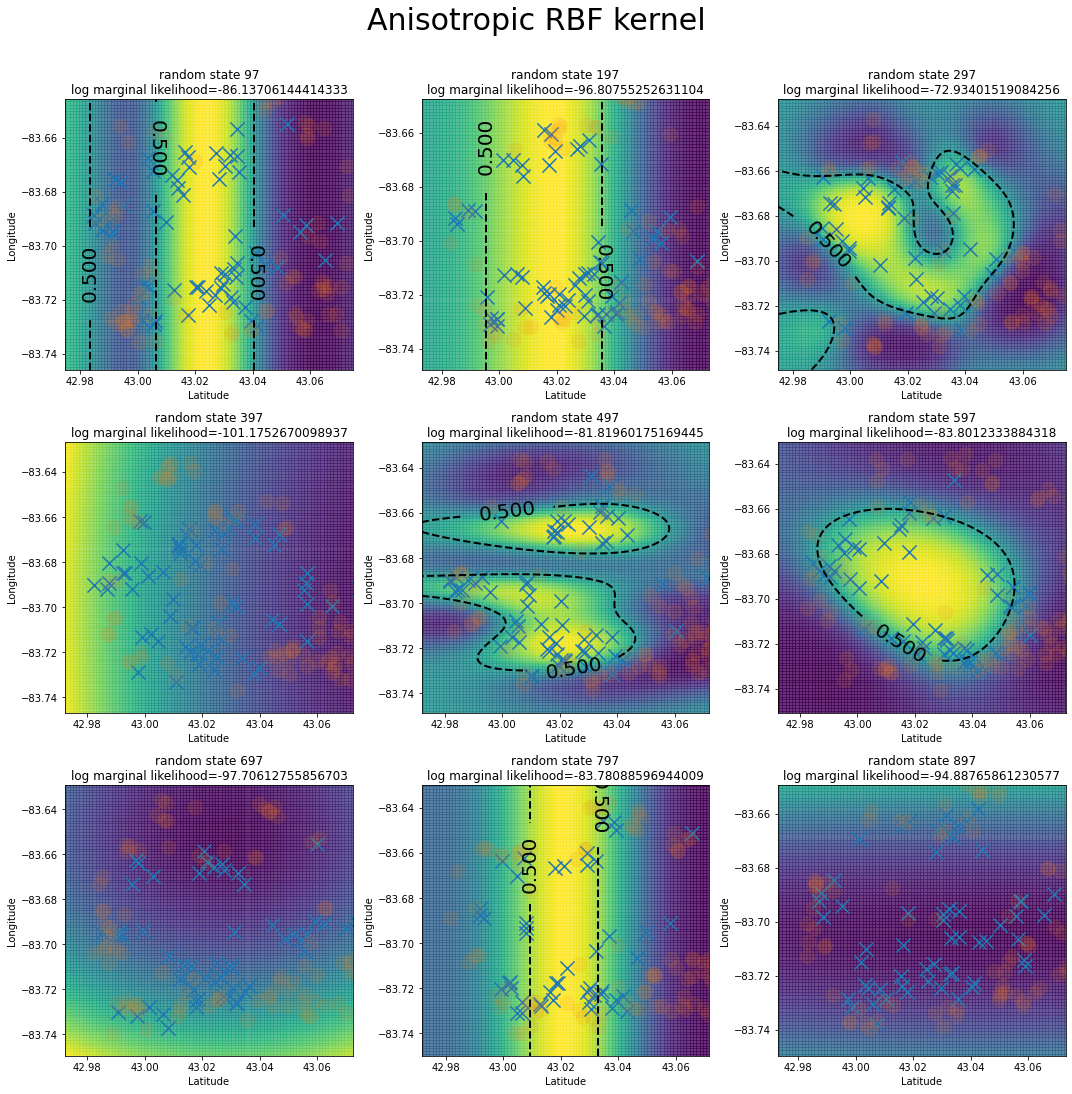

In [37]:
anisotropic_rbf_kernel = 1.0 * RBF([1.0, 1.0])

def plot_random_state_grid(nrows=3, ncols=3, kernel=anisotropic_rbf_kernel, suptitle='Anisotropic RBF kernel'):

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))

    random_states = [97+i*100 for i in range(nrows*ncols)]
    for i, r in enumerate(random_states):
        ax = axes[i//ncols, i%ncols]
        x_train, x_test, y_train, y_test = get_train_test(data, 200, random_state=r)
        model = GaussianProcessClassifier(kernel=kernel).fit(x_train,y_train)
        plot_model(ax, model, x_train, y_train, title = f'random state {r}')
    plt.suptitle(suptitle, y=1.01, fontsize=30)
    plt.tight_layout()
    plt.show()
    
plot_random_state_grid()

In [55]:
def test_hyperparameters():
    nrows, ncols = 5, 5
    l_min, l_max = .0003, .03
    sigma_min, sigma_max = 1e-10, 1e-4
    l_options = np.array([[l_min*(l_max/l_min)**(i/(ncols-1))]*2 for i in range(ncols)]).astype('float64')
    sigma_options = [sigma_min*(sigma_max/sigma_min)**(i/(nrows-1)) for i in range(nrows)]
    hyper_options = [(s, l) for s in sigma_options for l in l_options]
    for i, (s, l) in enumerate(hyper_options):
        print(s,l)
        
def get_hyperparameter_options(nrows, ncols, l_range=[3e-4,3e-3], sigma_range=[1e-4,1e-3]):
    # interpolates exponentially between the given min and max for l and sigma
    # using nrows and ncols to determine the number of steps
    l_min, l_max = l_range
    sigma_min, sigma_max = sigma_range
    
    l_options = np.array([[l_min*(l_max/l_min)**(i/(ncols-1))]*2 for i in range(ncols)])
    sigma_options = [sigma_min*(sigma_max/sigma_min)**(i/(nrows-1)) for i in range(nrows)]
    
    hyper_options = [(s, l) for s in sigma_options for l in l_options]
    return hyper_options

/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


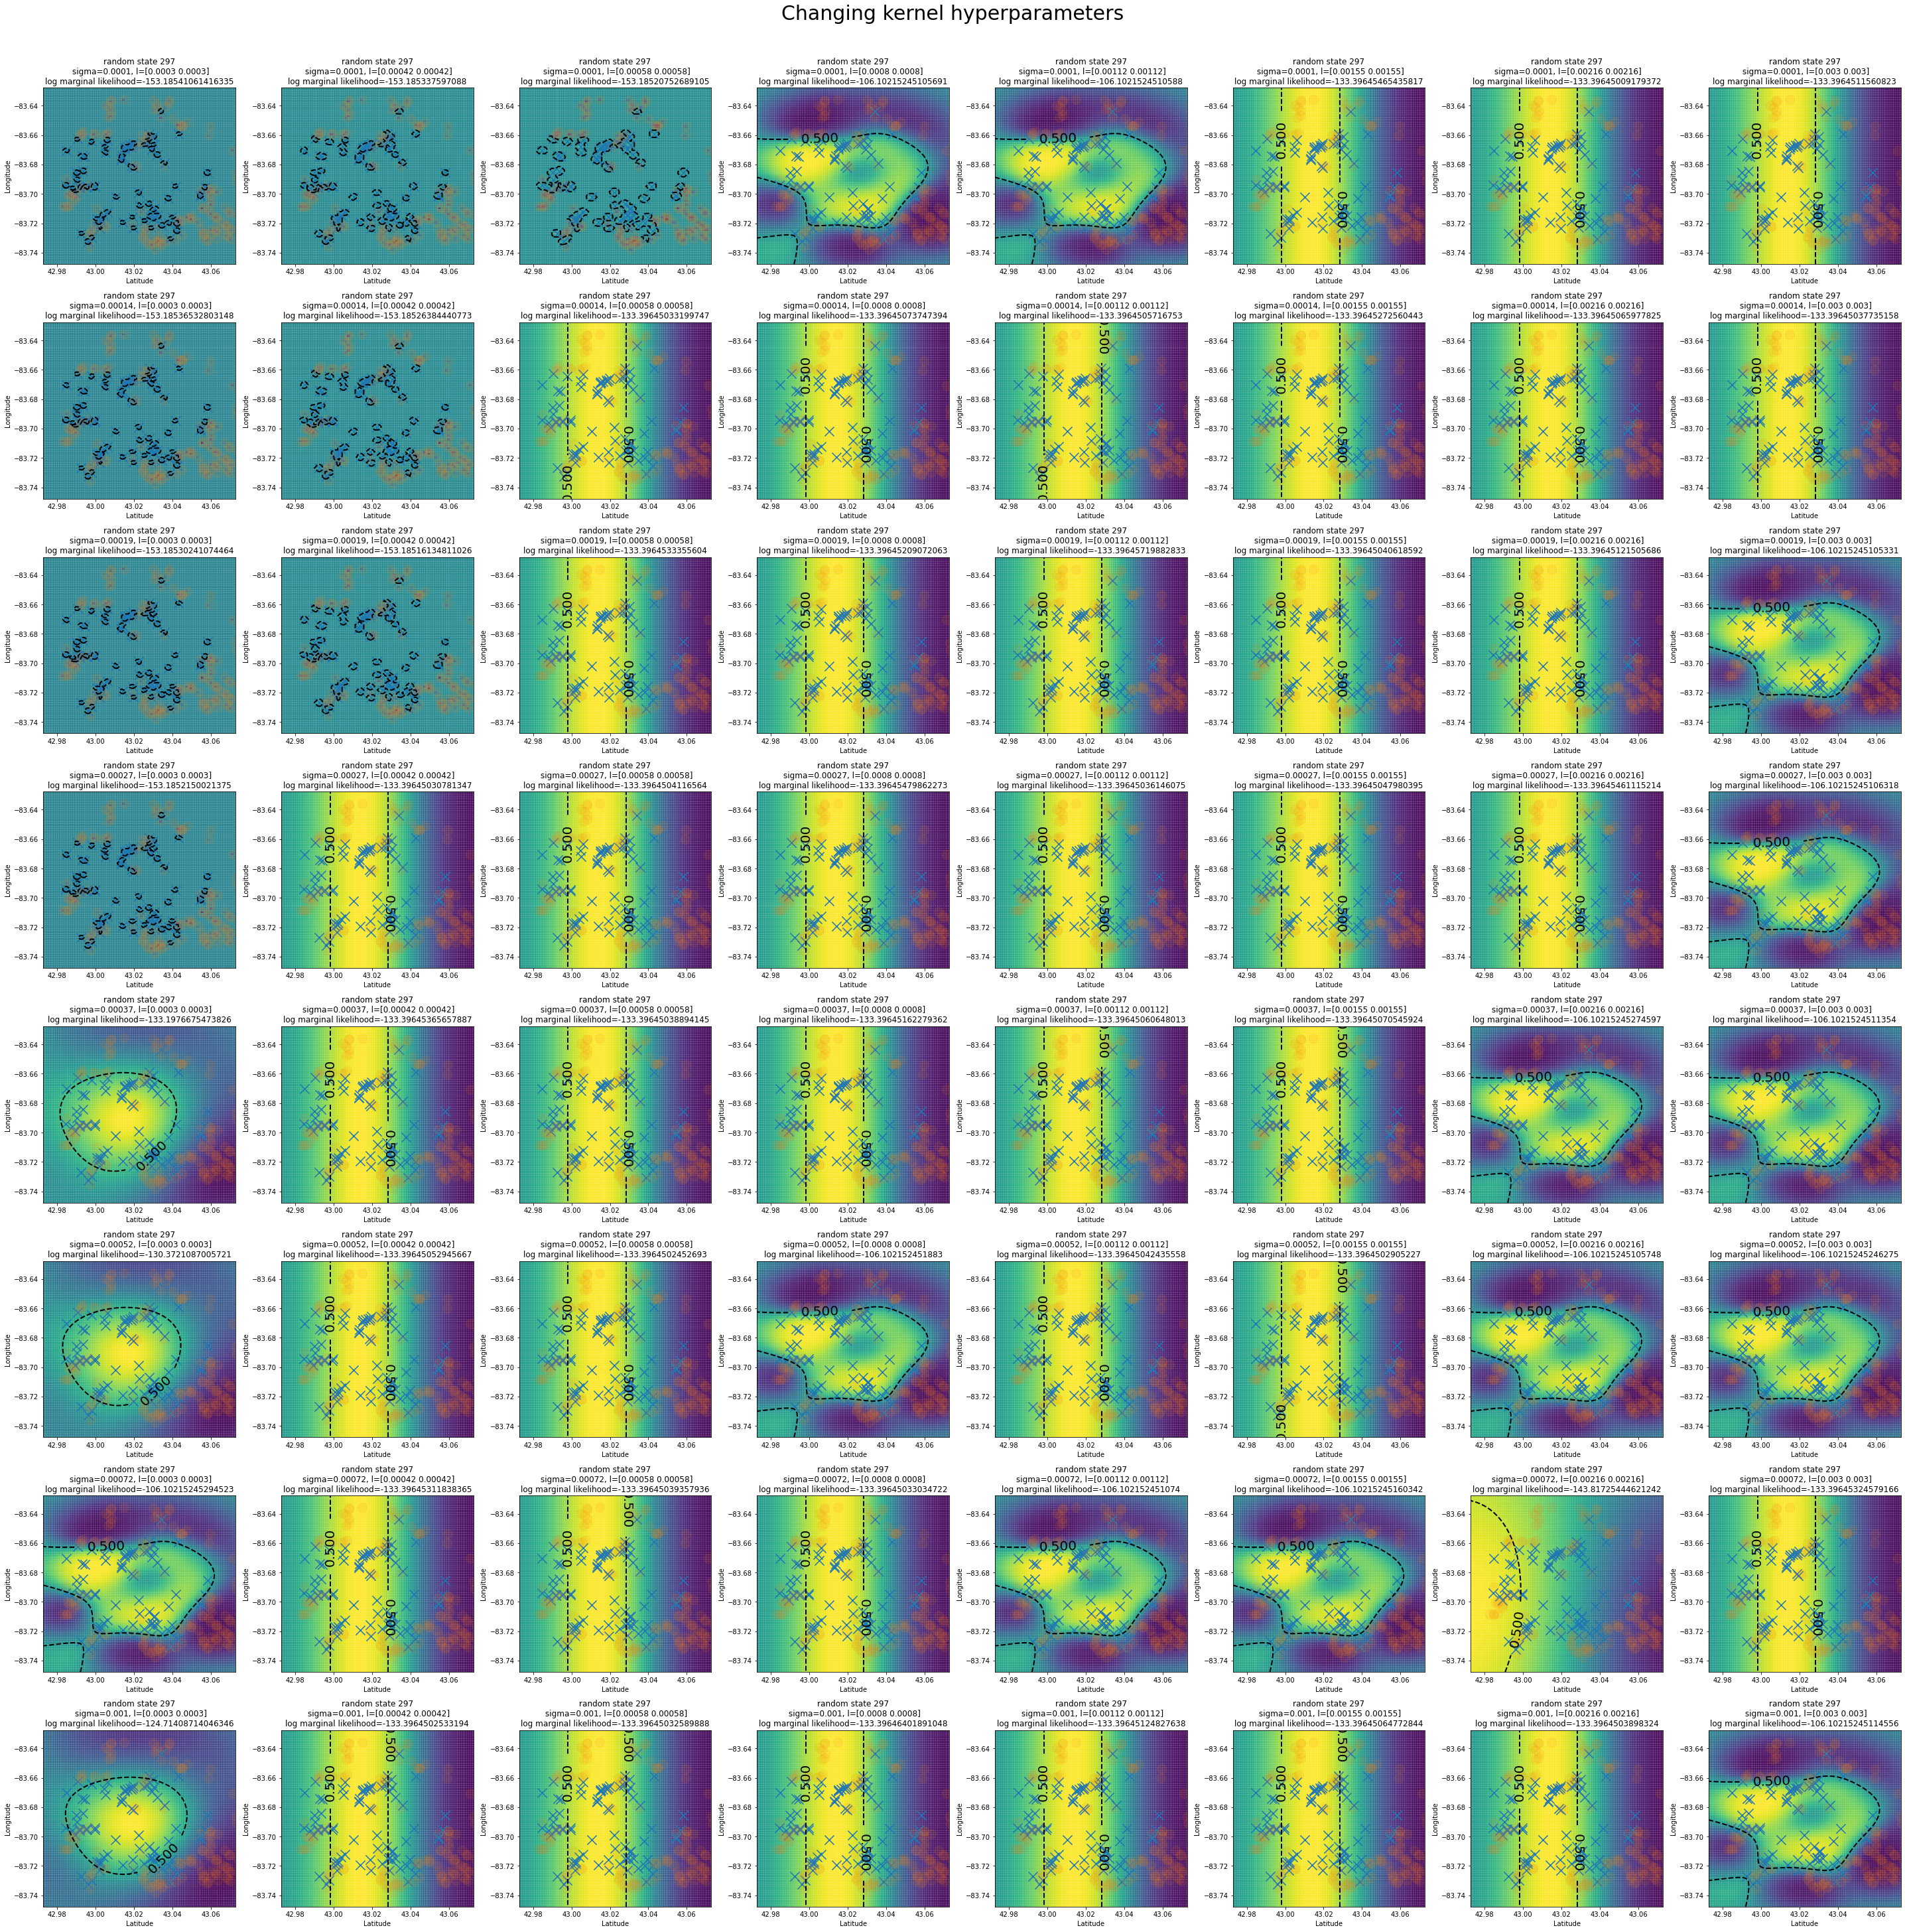

In [57]:
def plot_kernel_grid(nrows=3, ncols=3, suptitle='Changing kernel hyperparameters'):

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,5*nrows))
    
    x_train, x_test, y_train, y_test = get_train_test(data, 300, random_state=297)
    
    for i, (s, l) in enumerate(get_hyperparameter_options(nrows, ncols)):
        ax = axes[i//ncols, i%ncols]
        model = GaussianProcessClassifier(kernel= s*RBF(l)).fit(x_train,y_train)
        plot_model(ax, model, x_train, y_train, title = f'random state 297\n sigma={np.round(s,5)}, l={np.round(l,5)}')
    plt.suptitle(suptitle, y=1.01, fontsize=30)
    plt.tight_layout()
    plt.show()

plot_kernel_grid(nrows=8, ncols=8)
#plot_random_state_grid()


# cross validation to try different sklearn GP kernels

In [17]:
def gp_kernel_cross_validation():

    x_train, x_test, y_train, y_test = get_train_test(data, 200, 297)

    model = GaussianProcessClassifier()
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define grid
    grid = dict()
    grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
    # define search
    search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(x_train, y_train)
    
    means = results.cv_results_['mean_test_score']
    params = results.cv_results_['params']
    for mean, param in zip(means, params):
        print("mean test accuracy %.3f with: %r" % (mean, param))
        
gp_kernel_cross_validation()

mean test accuracy 0.761 with: {'kernel': 1**2 * RBF(length_scale=1)}
mean test accuracy 0.624 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
mean test accuracy 0.765 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
mean test accuracy 0.758 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
mean test accuracy 0.624 with: {'kernel': 1**2 * WhiteKernel(noise_level=1)}


/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/maxcembalest/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
<ipython-input-14-6ed9384818e6>:22: UserWarning: No contour levels were found within the data range.
  cs = ax.contour(x1v, x2v, ygrid_prob, levels=[0.5], colors='black', linestyles='dashed', linewidths=2)
<ipython-input-14-6ed9384818e6>:22: UserWarning: No contour levels were found within

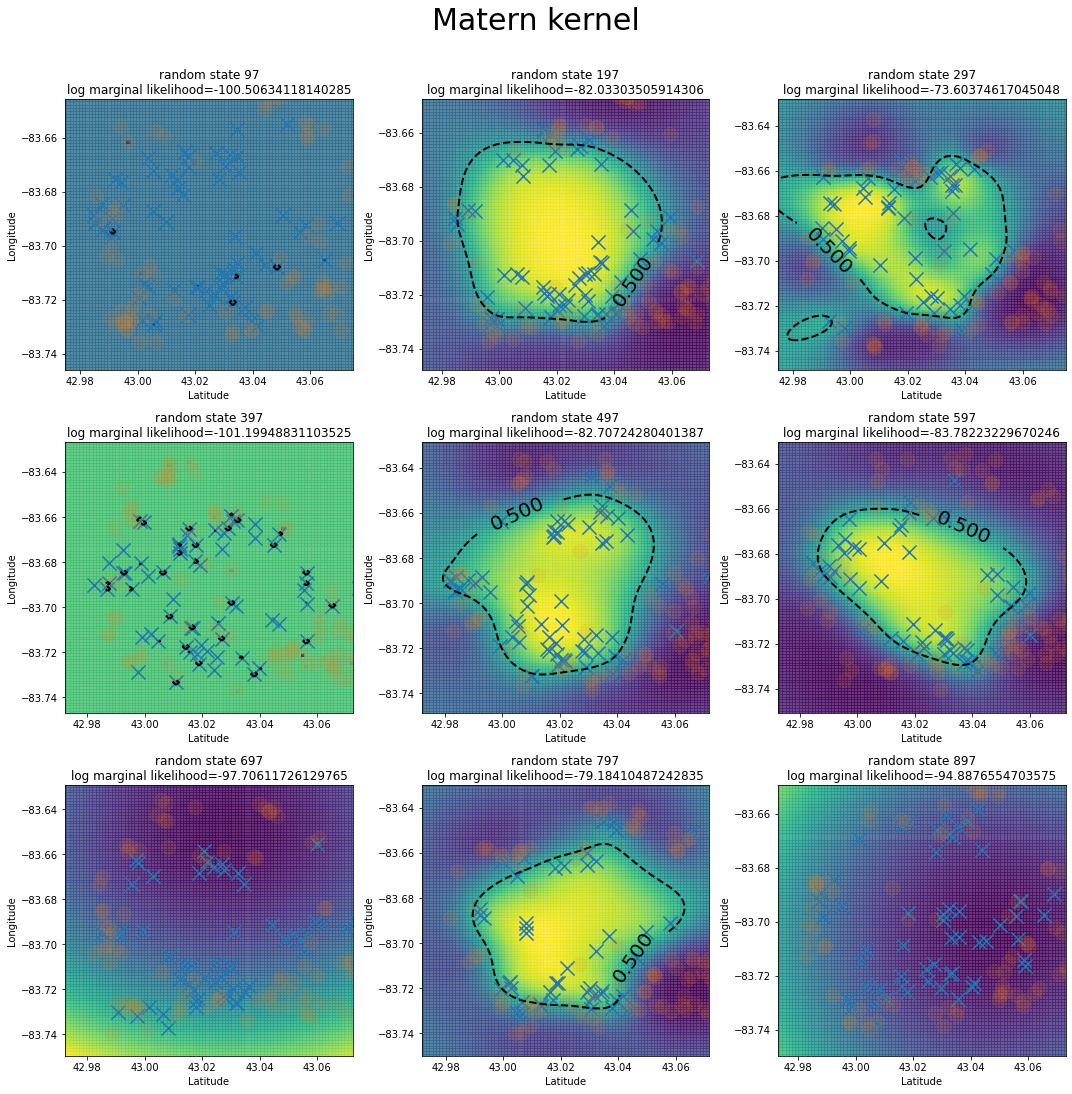

In [20]:
matern_kernel = 1.0*Matern(length_scale=1,nu=1.5)
plot_random_state_grid(kernel = matern_kernel, suptitle='Matern kernel')